- CNN policy ?
- grid search for HP tuning (OK)
- Increasingly difficult Environment
- Positive reward for populating increasingly "deep" blending tanks ?
- RL for chem sched paper (https://arxiv.org/pdf/2203.00636)
- Masking (https://sb3-contrib.readthedocs.io/en/master/modules/ppo_mask.html, https://arxiv.org/pdf/2006.14171)
    - Adding binary decision variables ?g  
    - Requires discrete action space (only integer flows -> treated as categories ?)
    - masking: disable incoming flows (resp. outgoing flows) for tanks at UB inv limit (resp. LB inv. limit), disable selling/buying when available = 0
    - multiple envs with multiple agents ? (MARL, https://arxiv.org/pdf/2103.01955)
        - Predict successive pipelines ("source > blend" then "blend > blend" (as many as required) then "blend > demand")
        - Each agent has access to the whole state
        - Action mask is derived from the previous agent's actions (0 if inventory at bounds or incoming flow already reserved, else 1)
        - https://github.com/Rohan138/marl-baselines3/blob/main/marl_baselines3/independent_ppo.py
- Safe RL: (https://proceedings.mlr.press/v119/wachi20a/wachi20a.pdf)
    - "Unsafe state" ? > Do not enforce constraints strictly, instead opt for early episode termination to show which states are unsafe ? 
    - Implementations:
        - https://pypi.org/project/fast-safe-rl/#description (Policy optimizers)
        - https://github.com/PKU-Alignment/safety-gymnasium/tree/main/safety_gymnasium (environments; "cost" ?)


1. Try other learning rates/CNN policies
2. Implement Masking with single agent
3. Try other ways to tell the model what are illegal/unsafe states (safe RL)
4. Try multiple agents

-----------------------

- Masking: Discretization of action space is too slow/might not work -> Need to implement masking for continuous action space
- Recurrent policy makes the most sense ? (window of demand forecasts)
- https://www.reddit.com/r/reinforcementlearning/comments/17l5b47/invalid_action_masking_when_action_space_is/
    - Suggestion of autoregressive model for having constraints respected: one predicted action is input to a second model
    - Suggestion of editing the distribution in such a way that the constraint is respected
- https://www.sciencedirect.com/science/article/pii/S0098135420301599
    - Choice of ELU activation ?
    - Choice of NN size ?
    - "The feature engineering in the net inventory means the network does not have to learn these relationships itself, which did help speed training." ?
- Simplify the problem (remove tanks 5 to 8), find the optimal solution with Gurobi

- remove all constraints except in/out
- Semantic Loss : https://arxiv.org/pdf/1711.11157
- MultiplexNet : https://arxiv.org/pdf/2111.01564
- Softmax with large coef to produce action mask
- Graph convolution NN instead of RNN ?
    - https://pytorch-geometric.readthedocs.io/en/latest/
    - Graph rep. learning - William L Hamilton

- DDPG
- Softmax
- ~~Remove non-selling rewards~~
- MultiplexNet
- Why softmax doesn't work ? -> gradient doesn't compute properly

- Finalize adjustment of flows
- Add more difficulty (bigger env)

In [1]:
# import gymnasium as gym
import json
import numpy as np
import torch as th
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import *
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecCheckNan

from envs import BlendEnv, flatten_and_track_mappings, reconstruct_dict
from models import *
from math import exp, log
import yaml

import warnings
warnings.filterwarnings("ignore")

( Regexp for Tensorboard coloring )

(1\\|2\\|3\\|4\\|5\\|6\\|7\\|8\\|9\\|10\\|11\\|12\\|13\\)

In [2]:
with open("configs/3.yaml", "r") as f:
    s = "".join(f.readlines())
    cfg = yaml.load(s, Loader=yaml.FullLoader)

![image info](../simple.png)

In [3]:
# th.autograd.set_detect_anomaly(True)

In [4]:
if cfg["clipped_std"]:
    policytype = CustomMLP_ACP_simplest_std
elif cfg["custom_softmax"]:
    policytype = CustomMLP_ACP_simplest_softmax
elif cfg["policytype"] == "MLP":
    policytype = "MlpPolicy"
elif cfg["policytype"] == "MLPtanh":
    policytype = CustomMLP_ACP_simplest_tanh
    
if cfg["optimizer"] == "PPO":
    optimizer_cls = PPO
elif cfg["optimizer"] == "DDPG":
    optimizer_cls = DDPG

if cfg["model"]["act_fn"] == "ReLU":
    act_cls = th.nn.ReLU
elif cfg["model"]["act_fn"] == "tanh":
    act_cls = th.nn.Tanh
elif cfg["model"]["act_fn"] == "sigmoid":
    act_cls = th.nn.Sigmoid

In [5]:
connections = {
    "source_blend": {
        "s1": ["j1", "j2", "j3", "j4"],
        "s2": ["j1", "j2", "j3", "j4"]
    },
    "blend_blend": {"j1": [], "j2": [], "j3": [], "j4": []},
    "blend_demand": {"j1": ["p1", "p2"],
        "j2": ["p1", "p2"],
        "j3": ["p1", "p2"],
        "j4": ["p1", "p2"]
    }
}

In [6]:
action_sample = {
    'source_blend':{
        's1': {'j1':1, 'j2':1, 'j3':1, 'j4':0}, # From s1 to b1, from s1 to b2 etc...
        's2': {'j1':1, 'j2':1, 'j3':0, 'j4':1},
    },
    
    'blend_blend':{},
    
    'blend_demand':{
        'j1': {'p1':1, 'p2':0},
        'j2': {'p1':1, 'p2':2},
        'j3': {'p1':1, 'p2':2},
        'j4': {'p1':1, 'p2':2}
    },
    
    "tau": {"s1": 10, "s2": 10},
    
    "delta": {"p1": 0, "p2": 0}
}
action_sample_flat, _ = flatten_and_track_mappings(action_sample)

In [7]:
tau0   = {'s1': [10, 10, 10, 0, 0, 0], 's2': [10, 10, 10, 0, 0, 0]}
delta0 = {'p1': [0, 0, 0, 10, 10, 10], 'p2': [0, 0, 0, 10, 10, 10]}
sigma = {"s1":{"q1": 0.06}, "s2":{"q1": 0.26}} # Source concentrations
sigma_ub = {"p1":{"q1": 0.16}, "p2":{"q1": 0.16}} # Demand concentrations UBs/LBs
sigma_lb = {"p1":{"q1": 0}, "p2":{"q1": 0}}
s_inv_lb = {'s1': 0, 's2': 0}
s_inv_ub = {'s1': 999, 's2': 999}
d_inv_lb = {'p1': 0, 'p2': 0}
d_inv_ub = {'p1': 999, 'p2': 999}
betaT_d = {'p1': 1, 'p2': 1} # Price of sold products
betaT_s = {'s1': cfg["env"]["product_cost"], 's2': cfg["env"]["product_cost"]} # Cost of bought products
b_inv_ub = {"j1": 30, "j2": 30, "j3": 30, "j4": 30} 
b_inv_lb = {j:0 for j in b_inv_ub.keys()}

In [8]:
env = BlendEnv(v = False, 
               D = cfg["env"]["D"], 
               Q = cfg["env"]["Q"], 
               P = cfg["env"]["P"], 
               B = cfg["env"]["B"], 
               Z = cfg["env"]["Z"], 
               M = cfg["env"]["M"],
               MAXFLOW = cfg["env"]["maxflow"],
               alpha = cfg["env"]["alpha"],
               beta = cfg["env"]["beta"],
               connections = connections, 
               action_sample = action_sample,
               tau0 = tau0,delta0 = delta0,
               sigma = sigma,
               sigma_ub = sigma_ub, sigma_lb = sigma_lb,
               s_inv_lb = s_inv_lb, s_inv_ub = s_inv_ub,
               d_inv_lb = d_inv_lb, d_inv_ub = d_inv_ub,
               betaT_d = betaT_d, betaT_s = betaT_s,
               b_inv_ub = b_inv_ub,
               b_inv_lb = b_inv_lb)

env = Monitor(env)
# env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, 
#                    norm_obs=cfg["obs_normalizer"], 
#                    norm_reward=cfg["reward_normalizer"])
# env = VecCheckNan(env, raise_exception=True)

In [9]:
env.mapping_obs

[(0, ['sources', 's1']),
 (1, ['sources', 's2']),
 (2, ['blenders', 'j1']),
 (3, ['blenders', 'j2']),
 (4, ['blenders', 'j3']),
 (5, ['blenders', 'j4']),
 (6, ['demands', 'p1']),
 (7, ['demands', 'p2']),
 (8, ['properties', 'j1', 'q1']),
 (9, ['properties', 'j2', 'q1']),
 (10, ['properties', 'j3', 'q1']),
 (11, ['properties', 'j4', 'q1']),
 (12, ['sources_avail_next_0', 's1']),
 (13, ['sources_avail_next_0', 's2']),
 (14, ['demands_avail_next_0', 'p1']),
 (15, ['demands_avail_next_0', 'p2']),
 (16, ['sources_avail_next_1', 's1']),
 (17, ['sources_avail_next_1', 's2']),
 (18, ['demands_avail_next_1', 'p1']),
 (19, ['demands_avail_next_1', 'p2']),
 (20, ['sources_avail_next_2', 's1']),
 (21, ['sources_avail_next_2', 's2']),
 (22, ['demands_avail_next_2', 'p1']),
 (23, ['demands_avail_next_2', 'p2']),
 (24, ['sources_avail_next_3', 's1']),
 (25, ['sources_avail_next_3', 's2']),
 (26, ['demands_avail_next_3', 'p1']),
 (27, ['demands_avail_next_3', 'p2']),
 (28, ['sources_avail_next_4', 's1

In [22]:
policy_kwargs = dict(
    net_arch=[dict(pi = [cfg["model"]["arch_layersize"]] * cfg["model"]["arch_n"], 
                   vf = [cfg["model"]["arch_layersize"]] * cfg["model"]["arch_n"])],
    activation_fn = act_cls,
    log_std_init = cfg["model"]["log_std_init"]
)

In [23]:
print(policytype)
model = optimizer_cls(policytype, 
                    env,
                    tensorboard_log = "./logs",
                    clip_range = cfg["model"]["clip_range"],
                    learning_rate = cfg["model"]["lr"],
                    ent_coef = cfg["model"]["ent_coef"],
                    policy_kwargs = policy_kwargs)

if cfg["starting_point"]:
    model.set_parameters(cfg["starting_point"])

MlpPolicy


In [24]:
import datetime

if type(model.policy) == CustomRNN_ACP:
    policytype = "CRNN"
elif type(model.policy) == CustomMLP_ACP_simplest_std:
    policytype = "CMLP"
else:
    policytype = "MLP"
    
entcoef = str(model.ent_coef) if type(model) == PPO else ""
cliprange = str(model.clip_range(0)) if type(model) == PPO else ""
model_name = f"models/simple/{cfg['id']}/{cfg['id']}_{datetime.datetime.now().strftime('%m%d-%H%M')}"

In [25]:
class CustomLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.log_stds = []
        self.total_rewards = []
        self.signal = True
        self.update1 = True
        self.print_flag = False

    def _on_step(self) -> bool:
        log_std: th.Tensor = self.model.policy.log_std
        t = self.locals["infos"][0]['dict_state']['t']
        
        if self.num_timesteps%2048 < 6 and t == 1: # start printing
            self.print_flag = True
            
        if self.print_flag:
            print("\nt:", t)
            if np.isnan(self.locals['rewards'][0]) or np.isinf(self.locals['rewards'][0]):
                print(f"is invalid reward {self.locals['rewards'][0]}")
            for i in ['obs_tensor', 'actions', 'values', 'clipped_actions', 'new_obs', 'rewards']:
                if i in self.locals:
                    print(f"{i}: " + str(self.locals[i]))
            if t == 6:
                stds = th.exp(self.model.policy.log_std).mean().item()
        
                if stds > 50:
                    print("clipping log-stds")
                    print("before: ", self.model.policy.log_std)
                    self.model.policy.log_std = nn.Parameter( 2*th.ones(self.model.policy.log_std.shape, requires_grad=True) )
                    print("after: ",  self.model.policy.log_std)
                    
                self.logger.record('train/learning_rate', self.model.learning_rate)
                self.logger.record('train/clip_range', self.model.clip_range(0))
                self.logger.record("train/std", th.exp(self.model.policy.log_std).mean().item())
                
                # if self.locals['rewards'][0] > 200 and self.update1:
                #     # self.training_env.set_attr('', 1e2)
                #     self.model.learning_rate = 1e2
                #     self.model.clip_range = 5e-2
                #     self.update1 = False
                
                self.print_flag = False
                print(f"\n\nLog-Std at step {self.num_timesteps}: {log_std.detach().numpy()}")
                self.log_stds.append(log_std.mean().item())
                self.total_rewards.append(self.locals['rewards'][0])
                print(f"\nAvg rewards over the last 100 episodes:{sum(self.total_rewards[-100:])/100} ; last reward: {self.total_rewards[-1]}")
                self.model.learning_rate
                print("\n\n\n\n\n\n")
                
        return True

In [26]:
log_callback = CustomLoggingCallback()
callback = CallbackList([log_callback])
model_name

'models/simple/3/3_0705-1707'

In [27]:
logpath = model_name[len("models/"):]
print(f"logging at {logpath}")
model.learn(total_timesteps = 100000, 
            progress_bar = False, 
            tb_log_name = logpath, 
            callback = callback,
            reset_num_timesteps = False
            )

logging at simple/3/3_0705-1707

t: 1
obs_tensor: tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10., 10.,
          0.,  0., 10., 10.,  0.,  0., 10., 10.,  0.,  0.,  0.,  0., 10., 10.,
          0.,  0., 10., 10.,  0.,  0., 10., 10.,  0.]])
actions: [[-6.1984297e-02 -2.4606434e-01  2.5531482e-03  5.9051428e-02
  -2.6110533e-01 -2.9601622e-01  1.5054165e-01  1.0394938e-02
  -2.3558119e-01 -1.1127918e-01  1.0132976e-04  1.2141154e-01
   2.7788594e-01 -1.5903588e-01 -1.0156837e-01 -1.2808603e-01
  -2.7372128e-01 -6.1988190e-02  1.3421952e-02 -1.6627008e-01]]
values: tensor([[1.1313]])
clipped_actions: [[0.0000000e+00 0.0000000e+00 2.5531482e-03 5.9051428e-02 0.0000000e+00
  0.0000000e+00 1.5054165e-01 1.0394938e-02 0.0000000e+00 0.0000000e+00
  1.0132976e-04 1.2141154e-01 2.7788594e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3421952e-02 0.0000000e+00]]
new_obs: [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10. 10.  0.  0. 10. 10

ValueError: Expected parameter loc (Tensor of shape (64, 20)) of distribution Normal(loc: torch.Size([64, 20]), scale: torch.Size([64, 20])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AddmmBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


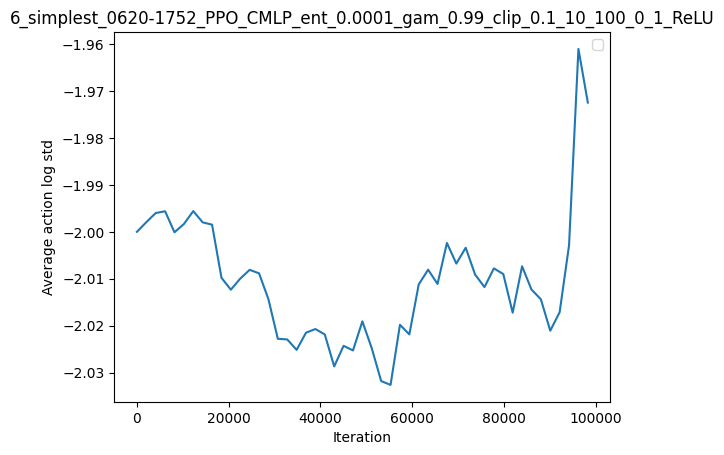

In [47]:
import matplotlib.pyplot as plt
import math
plt.plot([k*2048 for k in range(len(log_std_callback.log_stds))], [k for k in log_std_callback.log_stds])
plt.xlabel("Iteration")
plt.ylabel("Average action log std")
plt.title(model_name.split("/")[-1])
plt.legend()
plt.show()

In [15]:
model.save(model_name)

In [9]:
# M,Q,P,B,Z,D = 10, 0, 5, 5, 1, 0
M, Q, P, B, Z, D  = cfg["env"]["M"], cfg["env"]["Q"], cfg["env"]["P"], cfg["env"]["B"], cfg["env"]["Z"], 0
# M,Q,P,B,Z,D = 0, 0, 0, 0, 1, 0

In [10]:
env = BlendEnv(v = True, 
               M = M, Q = Q, P = P, B = B, Z = Z, D = D, 
               action_sample = action_sample, 
               connections = connections, 
               tau0 = tau0,
               delta0 = delta0,
               sigma = sigma,
               sigma_ub = sigma_ub,
               sigma_lb = sigma_lb,
               s_inv_lb = s_inv_lb,
               s_inv_ub = s_inv_ub,
               d_inv_lb = d_inv_lb,
               d_inv_ub = d_inv_ub,
               betaT_d = betaT_d,
               betaT_s = betaT_s,
               b_inv_ub = b_inv_ub,
               b_inv_lb = b_inv_lb)
env = Monitor(env)

In [10]:
env.mapping_act

[(0, ['source_blend', 's1', 'j1']),
 (1, ['source_blend', 's1', 'j2']),
 (2, ['source_blend', 's1', 'j3']),
 (3, ['source_blend', 's1', 'j4']),
 (4, ['source_blend', 's2', 'j1']),
 (5, ['source_blend', 's2', 'j2']),
 (6, ['source_blend', 's2', 'j3']),
 (7, ['source_blend', 's2', 'j4']),
 (8, ['blend_demand', 'j1', 'p1']),
 (9, ['blend_demand', 'j1', 'p2']),
 (10, ['blend_demand', 'j2', 'p1']),
 (11, ['blend_demand', 'j2', 'p2']),
 (12, ['blend_demand', 'j3', 'p1']),
 (13, ['blend_demand', 'j3', 'p2']),
 (14, ['blend_demand', 'j4', 'p1']),
 (15, ['blend_demand', 'j4', 'p2']),
 (16, ['tau', 's1']),
 (17, ['tau', 's2']),
 (18, ['delta', 'p1']),
 (19, ['delta', 'p2'])]

In [40]:
with th.autograd.set_detect_anomaly(True):
    obs = env.reset()
    obs, obs_dict = obs
    for k in range(env.T):
        action, _ = model.predict(obs, deterministic=True)
        print("\n\n   ",reconstruct_dict(action, env.mapping_act))
        obs, reward, done, term, _ = env.step(action)
        dobs = reconstruct_dict(obs, env.mapping_obs)
        print("\n    >>     ",dobs["sources"], dobs["blenders"], dobs["demands"])
        print("   " ,reward)
        



    {'source_blend': {'s1': {'j1': 50.0}}, 'blend_demand': {'j1': {'p1': 0.0}}, 'tau': {'s1': 50.0}, 'delta': {'p1': 0.0}}
[PEN] t1; s1:			bought too much (more than supply)
s1: b: 0.2
[PEN] t1; s1:			bought too little (resulting amount less than source tank LB)
Increased reward by 0 through tank population in s1
j1: inv: 0, in_flow_sources: 10.0, in_flow_blend: 0, out_flow_blend: 0, out_flow_demands: 0.0
Increased reward by 0.0 through tank population in j1
Increased reward by 0 through tank population in p1

    >>      {'s1': 0.0} {'j1': 10.0} {'p1': 0.0}
    -2.1


    {'source_blend': {'s1': {'j1': 0.0}}, 'blend_demand': {'j1': {'p1': 50.0}}, 'tau': {'s1': 50.0}, 'delta': {'p1': 0.0}}
[PEN] t2; s1:			bought too much (more than supply)
Increased reward by 0.0 through tank population in s1
j1: inv: 10.0, in_flow_sources: 0.0, in_flow_blend: 0, out_flow_blend: 0, out_flow_demands: 50.0
j1: b: 0.2
[PEN] t2; j1:			inventory OOB (resulting amount less than blending tank LB)
Increased 

In [253]:
# 0 (only once per episode)
episode_rewards = []
obs = env.reset()
obs, obs_dict = obs

In [262]:
# 1 Get first action
print(env.t)
action, _ = model.predict(obs, deterministic=True)

2


In [263]:
print(env.t)
d = reconstruct_dict(obs, env.mapping_obs)
print(d["sources"])
print(d["blenders"])
print(d["demands"])
print(d["properties"])

2
{'s1': 17.46205}
{'j1': 0.0}
{'p1': 0.0}
{'j1': {'q1': 0.0}}


In [264]:
# 2 Visualize action
print(env.t)
reconstruct_dict(action, env.mapping_act)

2


{'source_blend': {'s1': {'j1': 0.0}},
 'blend_demand': {'j1': {'p1': 30.307917}},
 'tau': {'s1': 8.731916},
 'delta': {'p1': 17.08481}}

In [265]:
# 3
# Step once: get 2nd action
print(env.t)
obs, reward, done, term, _ = env.step(action)

2


In [207]:
# 4 Visualize new state
print(env.t)
d = reconstruct_dict(obs, env.mapping_obs)
print(d["sources"])
print(d["blenders"])
print(d["demands"])
print(d["properties"])

3
{'s1': 26.193966}
{'j1': 0.0}
{'p1': 0.0}
{'j1': {'q1': 0.0}}
